<a href="https://colab.research.google.com/github/addy4/battery-performance-simulation/blob/feature%2Fdemo/perfomance_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Battery perfomance simulation based on hybrid approach of
1. Mathematical Model (Based on Electrochemical Nature of Cell)
2. Neural-Networks (Based on Data consisting of battery's state parameters)

For this PoC, we have considered a Lithium-IoN battery which is used extensively in Electric Vehicles.

In [1]:
# Uploading the dataset
from google.colab import files
data_to_load = files.upload()

Saving discharge.csv to discharge.csv


In [3]:
import io
import pandas as pd
import numpy as np
df2 = pd.read_csv(io.BytesIO(data_to_load['discharge.csv']))

In [4]:
df2.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,id_cycle,type,ambient_temperature,time,Battery
0,3.974871,-2.012528,24.389085,1.9982,3.062,35.703,1.856487,1,discharge,24,2008.0,B0005
1,3.951717,-2.013979,24.544752,1.9982,3.030,53.781,1.856487,1,discharge,24,2008.0,B0005
2,3.934352,-2.011144,24.731385,1.9982,3.011,71.922,1.856487,1,discharge,24,2008.0,B0005
3,3.920058,-2.013007,24.909816,1.9982,2.991,90.094,1.856487,1,discharge,24,2008.0,B0005
4,3.907904,-2.014400,25.105884,1.9982,2.977,108.281,1.856487,1,discharge,24,2008.0,B0005


Visual representation of data to show unique values type, battery and temperature

In [5]:
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

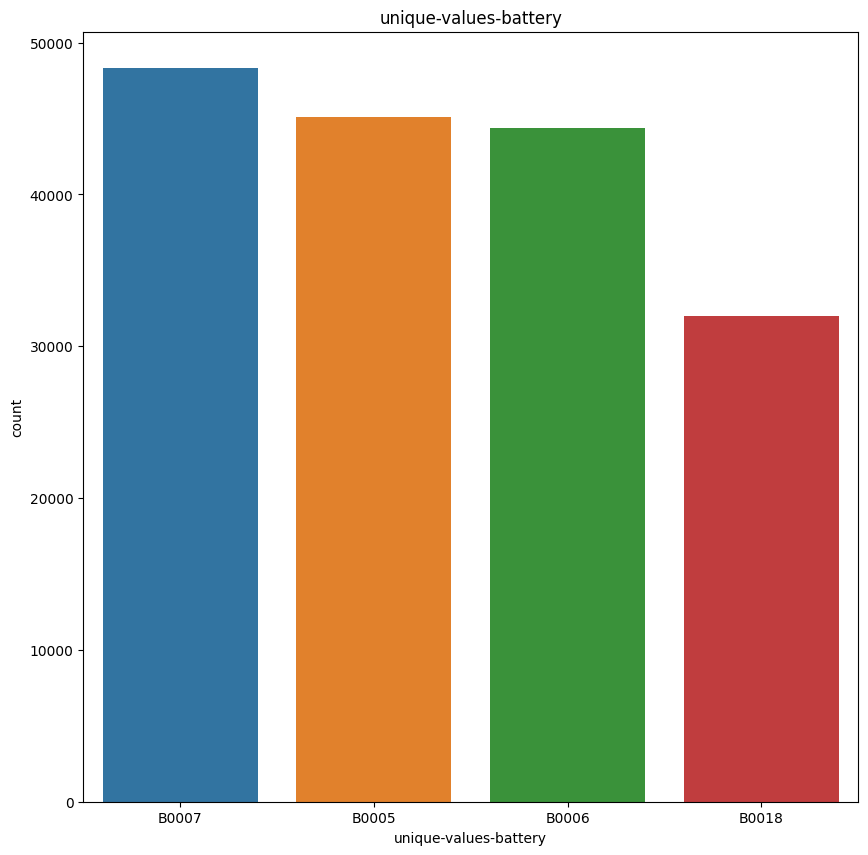

In [6]:
# Get unique values and their counts (battery)
value_counts = df2['Battery'].value_counts().reset_index()
value_counts.columns = ['unique-values-battery', 'count']

# Create a bar plot with Seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='unique-values-battery', y='count', data=value_counts)
plt.xlabel('unique-values-battery')
plt.ylabel('count')
plt.title('unique-values-battery')
plt.show()

In [7]:
df2 = df2[df2['Battery'] == 'B0005']
df2 = df2[df2['Temperature_measured'] > 36] #choose battery B0005
#df['Time'] =pd.to_datetime(df['Time'], unit='s')
dfb = df2.groupby(['id_cycle']).max()
dfb['Cumulated_T'] = dfb['Time'].cumsum()

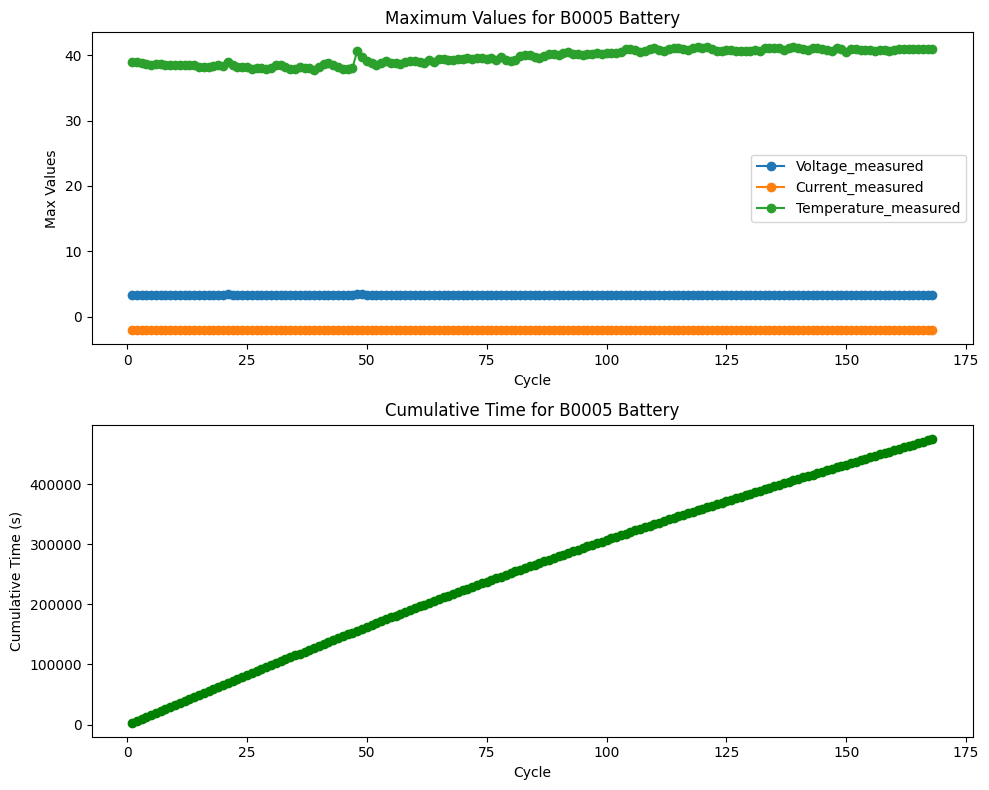

In [30]:
import matplotlib.pyplot as plt

# Create subplots for multiple visualizations
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Initilization
temp = 45
chargetime = 2400
kcoeff = 0.13

# Visualization 1: Maximum Values
axes[0].plot(dfb.index, dfb['Voltage_measured'], label='Voltage_measured', marker='o')
axes[0].plot(dfb.index, dfb['Current_measured'], label='Current_measured', marker='o')
axes[0].plot(dfb.index, dfb['Temperature_measured'], label='Temperature_measured', marker='o')
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Max Values')
axes[0].set_title('Maximum Values for B0005 Battery')
axes[0].legend()

# Visualization 2: Cumulative Time
axes[1].plot(dfb.index, dfb['Cumulated_T'], marker='o', color='green')
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Cumulative Time (s)')
axes[1].set_title('Cumulative Time for B0005 Battery')

plt.tight_layout()
plt.show()

In [31]:
dfb.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,type,ambient_temperature,time,Battery,Cumulated_T,C. Capacity
id_cycle,,,,,,,,,,,,,
1,3.382031,-2.010069,38.904112,1.9984,2.466,3346.937,1.856487,discharge,24,2008.0,B0005,3346.937,1.853684
2,3.402555,-2.009236,38.934590,1.9984,2.475,3328.828,1.846327,discharge,24,2008.0,B0005,6675.765,1.850850
3,3.398392,-2.008818,38.743649,1.9984,2.466,3309.422,1.835349,discharge,24,2008.0,B0005,9985.187,1.848030
4,3.387662,-2.009841,38.672511,1.9982,2.454,3309.719,1.835263,discharge,24,2008.0,B0005,13294.906,1.845242
5,3.381617,-2.009336,38.558828,1.9984,2.449,3307.688,1.834646,discharge,24,2008.0,B0005,16602.594,1.842473


In [32]:
import plotly.express as px

# Create a scatter matrix plot
fig = px.scatter_matrix(dfb.drop(columns=['Time', 'type', 'ambient_temperature', 'time', 'Battery']))

# Update trace properties
fig.update_traces(marker=dict(size=2, color='crimson', symbol='square'), diagonal_visible=True)

# Update layout settings
fig.update_layout(
    title='Battery dataset',
    width=900,
    height=1200,
    plot_bgcolor='#f2f8fd',
    paper_bgcolor='white',
    template='plotly_white',
    font=dict(size=7)
)

# Show the plot
fig.show()

Physical-mathematical model for the Li-Ion battery is represented by:
<br>
<center> $L = 1 − (1 − L' )e^{-f_d}$ </center><br>

Where,

$L$ is the battery lifetime,

$L'$ the initial battery lifetime,

$f_d$ is a Linearized degradation rate per unit time and per cycle.  

It can be described as:<br>
<center> $f_d = f_d(t, δ, σ, T_c)$ </center><br>

where,

$t$ is charging time,

δ is the cycle depth of discharge,

σ is the cycle average state of charge,

$T_c$ is cell temperature.

The equation for battery capacity could be written as follows:<br>
<center> $C = C_0e^{f_d}$ </center><br>

We have empirically found that $f_d$ aproximates to:
<center> $f_d = \frac{kT_Ci}{t}$ </center><br>

where $k= $ 0.13, $i$ the cycle number and $t$ the charge time for every cycle.

- [1] *Xu, Bolun & Oudalov, Alexandre & Ulbig, Andreas & Andersson, Göran & Kirschen, D.s. (2016). Modeling of Lithium-Ion Battery Degradation for Cell Life Assessment. IEEE Transactions on Smart Grid. 99. 1-1. 10.1109/TSG.2016.2578950.*

**Using the above mathematical model, we create the Level-1 Digital Twin for our 🔋 (battery) ... Wait for the next part, we will make it more accurate!!**

In [34]:
from math import e

fig = go.Figure()

cycles = np.arange(1,167,1)

# Calculate Capacity for Predicted Values as Per Physical Model


L_e = 1-e**(-kcoeff*cycles*temp/chargetime)
X2_in_e = -(L_e*dfb['Capacity'].iloc[0:1].values[0]) + dfb['Capacity'].iloc[0:1].values[0]

# Convert to Array
X2_in_e = np.column_stack((cycles, X2_in_e))

# Final Dataframe
df_op = pd.DataFrame(X2_in_e, columns=['id_cycle', 'predicted_capacity']).set_index('id_cycle')
X2_in_e = df_op['predicted_capacity']

# Add Trace
fig.add_trace(go.Scatter(x=cycles,
                         y=X2_in_e,
                         mode='lines',
                         name='Physical model',
                         line=dict(color='navy',
                                   width=2.5,
                                   )))

fig.add_trace(go.Scatter(x=dfb.index,
                         y=dfb['Capacity'],
                         mode='markers',
                         marker=dict(
                              size=4,
                              color='grey',
                              symbol='cross'
                                 ),
                         name='NASA dataset',
                         line_color='navy'))

fig.update_layout(
    title="Physical model comparison ",
    xaxis_title="Cycles",
    yaxis_title="𝐶, Capacity [Ahr]")

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="left",
    x=0.8
))

As you can see, the actual results are very close to the results calculated by the L1 DT Model (**L1 Digital Twin Model**). Below are the calculations for these deviations

Calculated Error: 8.47%

However, this means that out of 160000 measurements we will have **13552 errors**

Increasing the accuracy by adopting the hybrid approach.

Training a neural networks model on this data!

**Mathematical Model + Deep Learning**

In [18]:
from math import e
L = (dfb['Capacity']-dfb['Capacity'].iloc[0:1].values[0])/-dfb['Capacity'].iloc[0:1].values[0]
K = 0.13
L_1 = 1-e**(-K*dfb.index*dfb['Temperature_measured']/(dfb['Time']))
dfb['C. Capacity'] = -(L_1*dfb['Capacity'].iloc[0:1].values[0]) + dfb['Capacity'].iloc[0:1].values[0]

In [27]:
dfb['Capacity']

id_cycle
1      1.856487
2      1.846327
3      1.835349
4      1.835263
5      1.834646
         ...   
164    1.293464
165    1.288003
166    1.287453
167    1.309015
168    1.325079
Name: Capacity, Length: 168, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import SGD

#Define inputs and outputs
X_in = dfb['C. Capacity']          # input: the simulation time series
X_out = dfb['Capacity'] - dfb['C. Capacity']   # output: difference between measurement and simulation

X_in_train, X_in_test, X_out_train, X_out_test = train_test_split(X_in, X_out, test_size=0.33)

In [20]:
#The Dense function in Keras constructs a fully connected neural network layer, automatically initializing the weights as biases.
#First hidden layer
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [26]:
# Train
epochs = 100
loss = "mse"
model.compile(optimizer='adam',
              loss=loss,
              metrics=['mae'], #Mean Absolute Error
             )
history = model.fit(X_in_train, X_out_train,
                    shuffle=True,
                    epochs=epochs,
                    batch_size=20,
                    validation_data=(X_in_test, X_out_test),
                    verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 34ms/step - loss: 0.0018 - mae: 0.0361 - val_loss: 0.0012 - val_mae: 0.0298
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0013 - mae: 0.0282 - val_loss: 6.9963e-04 - val_mae: 0.0218
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0279 - val_loss: 7.4077e-04 - val_mae: 0.0233
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 9.3943e-04 - mae: 0.0246 - val_loss: 6.9984e-04 - val_mae: 0.0221
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0280 - val_loss: 6.9828e-04 - val_mae: 0.0220
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 8.1508e-04 - val_mae: 0.0247
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0277 - val_loss: 6.9958e-04 - val_mae: 0.0218
Epoch 8/100
6/6 [==============================] - 0s 8ms/step 

In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(0, epochs, 1),
                         y=history.history['mae'],
                         mode='lines',
                         name=f'Training MAE',
                         marker_size=3,
                         line_color='orange'))
fig.add_trace(go.Scatter(x=np.arange(0, epochs, 1),
                         y=history.history['val_mae'],
                         mode='lines',
                         name=f'Validation MAE',
                         line_color='grey'))

fig.update_layout(
                  title="Network training",
                  xaxis_title="Epochs",
                  yaxis_title=f"Mean Absolute Error")
fig.update_layout({'plot_bgcolor': '#f2f8fd' ,
                   'paper_bgcolor': 'white',},
                   template='plotly_white')

fig.show()

In [109]:
X_twin = X_in + model.predict(X_in).reshape(-1)

fig = go.Figure()

fig.add_trace(go.Scatter(x=dfb.index,
                         y=X_twin,
                         mode='lines',
                         name=f'Hybrid digital twin (Predicted by Model)',
                         line=dict(color='firebrick', width=3)))

fig.add_trace(go.Scatter(x=dfb.index,
                         y=dfb['Capacity'],
                         mode='markers',
                         marker=dict(
                              size=4,
                              color='grey',
                              symbol='cross'
                                 ),
                         name=f'Observed capacity (NASA Dataset Points)',
                         line_color='navy'))
fig.update_layout(
    title="Battery Capacity Estimation by Hybrid Digital Twin Model",
    xaxis_title="Cycles",
    yaxis_title="Capacity in Ahr")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="left",
    x=0.77
))
fig.update_layout({'plot_bgcolor': '#f2f8fd',
                  'paper_bgcolor': 'white',},
                   template='plotly_white')

fig.show()

6/6 [==============================] - 0s 2ms/step


In [123]:
# Define actual values and predicted values as arrays or lists

# Calculate absolute percentage error for each data point
absolute_percentage_error1 = [(abs(dfb['Capacity'] - X_twin) / dfb['Capacity']) * 100 for actual, predicted in zip(dfb['Capacity'], X_twin)]

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(absolute_percentage_error1)

**Error reduced to 1.4%**

In [124]:
# Last Value
cycles = np.arange(168,500,1)
temperature = dfb['Temperature_measured'].iloc[167]
time = dfb['Time'].iloc[167]

# Calculate Capacity for Predicted Values as Per Physical Model Twin
K = 0.13
L_e = 1-e**(-K*cycles*temperature/time)
X_in_e = -(L_e*dfb['Capacity'].iloc[0:1].values[0]) + dfb['Capacity'].iloc[0:1].values[0]

# Convert to Array
X_in_e = np.column_stack((cycles, X_in_e))

# Final Dataframe
df_op = pd.DataFrame(X_in_e, columns=['id_cycle', 'predicted_capacity']).set_index('id_cycle')
X_in_e = df_op['predicted_capacity']
C_twin_e = X_in_e + model.predict(X_in_e).reshape(-1)

# Visuals
fig = go.Figure()


fig.add_trace(go.Scatter(x=cycles,
                         y=C_twin_e,
                         mode='lines',
                         name=f'C Digital twin (predicted)',
                         line=dict(color='crimson',
                                   width=3,
                                   dash='dash'
                                  )))

fig.add_trace(go.Scatter(x=dfb.index,
                         y=X_twin,
                         mode='lines',
                         name=f'C Digital twin',
                         line=dict(color='crimson',
                                  width=2)))



fig.add_trace(go.Scatter(x=dfb.index,
                         y=dfb['Capacity'],
                         mode='markers',
                         marker=dict(
                              size=4,
                              color='grey',
                              symbol='cross'
                                 ),
                         name=f'Observed capacity (NASA Dataset Points)',
                         line_color='navy'))

fig.update_layout(
    title="Battery capacity prediction",
    xaxis_title="Cycles",
    yaxis_title="Battery capacity [Ahr]")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="left",
    x=0.72
))
fig.update_layout({'plot_bgcolor': '#f2f8fd',
                  'paper_bgcolor': 'white',},
                   template='plotly_white')

fig.show()

11/11 [==============================] - 0s 2ms/step


**BELOW ARE THE INFERENCES DRAWN BY THE ABOVE MODEL**

In [56]:
def add_plot_performance(charging_time, temperature_cell, k_val, colorLine, fig, totalCyles, intial_capacity):
  cycles = np.arange(1,totalCyles,1)

  # Calculate Capacity for Predicted Values as Per Physical Model
  K = k_val
  L_e = 1-e**(-K*cycles*temperature_cell/charging_time)
  #X2_in_e = -(L_e*dfb['Capacity'].iloc[0:1].values[0]) + dfb['Capacity'].iloc[0:1].values[0]
  X2_in_e = -(L_e*intial_capacity) + intial_capacity

  # Convert to Array
  X2_in_e = np.column_stack((cycles, X2_in_e))

  # Final Dataframe
  df_op = pd.DataFrame(X2_in_e, columns=['id_cycle', 'predicted_capacity']).set_index('id_cycle')
  X2_in_e = df_op['predicted_capacity']
  global predictions
  predictions = X2_in_e

  # Make Twin
  C2_twin_e = X2_in_e + model.predict(X2_in_e).reshape(-1)

  # Add Trace
  fig.add_trace(go.Scatter(x=cycles,
                         y=C2_twin_e,
                         mode='lines',
                         name='Temp = {}, Charging Time = {}, K = {}'.format(temperature_cell, charging_time, k_val),
                         line=dict(color=colorLine,
                                   width=3
                                  )))

In [102]:
def percent_capacity(prediction_points, x):
  print(prediction_points[x])
  print(prediction_points[1])
  capacity_percentage = (prediction_points[x]/prediction_points[1])*100
  return capacity_percentage

In [103]:
# figure
fig = go.Figure()

# dataframe
global predictions

# add
add_plot_performance(2000, 20, 0.13, "crimson", fig, 500, 1.856487)
add_plot_performance(2000, 50, 0.13, "navy", fig, 500, 1.856487)
add_plot_performance(4000, 50, 0.13, "green", fig, 500, 1.856487)

# show
fig.update_layout(
    title="Battery capacity prediction at various temp.",
    xaxis_title="Cycles",
    yaxis_title="Battery capacity [Ahr]")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="left",
    x=0.72
))
fig.update_layout({'plot_bgcolor': '#f2f8fd',
                  'paper_bgcolor': 'white',},
                   template='plotly_white')

fig.show()

16/16 [==============================] - 0s 1ms/step


**INFERENCES**:


1.   Lower temperatures enhance the battery life time, this suggest us that we should aim to maintain lower temprature ranges for the EV battery surroundings.
2.   If temp. range is high, the user can be encouraged to have larger charging times to have a better battery life-cycle / better battery capacity.



In [107]:
# figure
fig = go.Figure()

# add
add_plot_performance(4000, 50, 0.08, "navy", fig, 500, 1.856487)
add_plot_performance(4000, 50, 0.13, "green", fig, 500, 1.856487)
add_plot_performance(4000, 50, 0.17, "crimson", fig, 500, 1.856487)

# show
fig.update_layout(
    title="Battery capacity prediction at SOC coeffecients.",
    xaxis_title="Cycles",
    yaxis_title="Battery capacity [Ahr]")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="left",
    x=0.72
))
fig.update_layout({'plot_bgcolor': '#f2f8fd',
                  'paper_bgcolor': 'white',},
                   template='plotly_white')

fig.show()

16/16 [==============================] - 0s 1ms/step


**INFERENCES**


1.   Low SoC (state of charge) battery coefficients are beneficial.
2.   This can be used by chemical-battery manufacturers to decide the composition for our batteries. Low SoC coefficients can thus be achieved by:

*   Battery Chemistry
*   Electrode Material
*   Electrolyte's sepecfic gravity

SoC coefficient for battery can be expressed as a percentage change in capacity for a given change in SOC over a specific period.













In [105]:
# figure
fig = go.Figure()

# add
add_plot_performance(2000, 50, 0.13, "navy", fig, 500, 2)

# show
fig.update_layout(
    title="Battery capacity prediction at various temp.",
    xaxis_title="Cycles",
    yaxis_title="Battery capacity [Ahr]")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="left",
    x=0.72
))
fig.update_layout({'plot_bgcolor': '#f2f8fd',
                  'paper_bgcolor': 'white',},
                   template='plotly_white')

fig.show()

16/16 [==============================] - 0s 1ms/step


VALUE ESTIMATION FOR COST DEPRECIATION:


*   Initial set cycles lead to sharp decrease in value!

This curve can also tell us about the value/resale price estimation of EVs as battery capacity plays a major role in it!





In [108]:
percent_capacity(predictions, 122)

1.432521233502941
1.8525461537570818


77.32715487804158